In [21]:
# import libraries
import xarray as xr
from pystac import Item, Collection
import pystac
from datetime import datetime
from shapely.geometry import box, mapping
from xstac import xarray_to_stac
import glob
import json
import shapely
import numpy as np
import geopandas as gpd
import pandas as pd
import time, threading, random
from concurrent.futures import ThreadPoolExecutor
from urllib3.connectionpool import HTTPConnectionPool, HTTPSConnectionPool
from concurrent.futures import ThreadPoolExecutor
import fsspec

In [22]:
ds = xr.open_zarr("https://eoresults.esa.int/e/earthcode/seasfire_tests/seasfire_v0.4.zarr", chunks={})

burned = (ds.fcci_ba * ds.area).where(ds.fcci_ba_valid_mask == 1, drop=True)
drivers = xr.Dataset({"frp": ds.cams_frpfire, "fwi": ds.fwi_mean, "dc": ds.drought_code_mean})
annual = xr.merge([burned.rename("burned"), drivers]).resample(time="1Y").sum()
result = annual.groupby(ds.biomes).sum(("latitude", "longitude")).compute()

KeyboardInterrupt: 

In [ ]:
import xarray as xr
import dask.array as da
from sklearn.cluster import KMeans
ds = xr.open_zarr("https://eoresults.esa.int/e/earthcode/seasfire_tests/seasfire_v0.4.zarr")

feat = xr.concat([ds.cams_frpfire.isel(time=slice(-500, None)).mean("time"),
                  ds.fwi_mean.isel(time=slice(-500, None)).mean("time")], dim="feature") \
         .isel(latitude=slice(None, None, 4), longitude=slice(None, None, 4)) \
         .stack(p=("latitude", "longitude")).transpose("p", "feature").fillna(0)

labels = xr.DataArray(KMeans(4, n_init="auto").fit_predict(feat.compute().values),
                      coords={"p": feat.p}, dims="p").unstack("p")


# ds = xr.open_zarr("https://eoresults.esa.int/e/earthcode/seasfire_tests/seasfire_v0.4.zarr")
# X = xr.concat([ds.cams_frpfire.mean("time"), ds.fwi_mean.mean("time"), ds.drought_code_mean.mean("time")], dim="feature") \
#       .stack(p=("latitude", "longitude")).transpose("p", "feature")

# Xc = X.fillna(0).compute()
# labels = xr.DataArray(KMeans(5, n_init="auto").fit_predict(Xc.values), coords={"p": X.p}, dims="p").unstack("p")

# labels.plot(x="longitude", y="latitude")


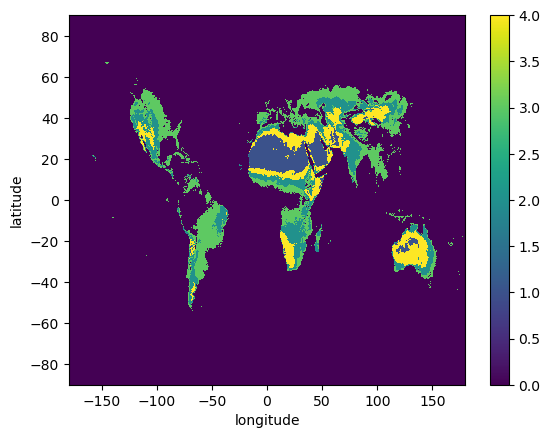

In [ ]:
import xarray as xr
import dask.array as da
from sklearn.cluster import KMeans
# ds = xr.open_zarr("https://eoresults.esa.int/e/earthcode/seasfire_tests/seasfire_v0.4.zarr")


ds = xr.open_zarr("https://s3.waw4-1.cloudferro.com/EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr")
X = xr.concat([ds.cams_frpfire.mean("time"), ds.fwi_mean.mean("time"), ds.drought_code_mean.mean("time")], dim="feature") \
      .stack(p=("latitude", "longitude")).transpose("p", "feature")

Xc = X.fillna(0).compute()
labels = xr.DataArray(KMeans(5, n_init="auto").fit_predict(Xc.values), coords={"p": X.p}, dims="p").unstack("p")

labels.plot(x="longitude", y="latitude")


In [ ]:
import xarray as xr
from sklearn.cluster import KMeans

ds = xr.open_zarr("https://s3.waw4-1.cloudferro.com/EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr", chunks={})

feat = xr.concat([ds.cams_frpfire.isel(time=slice(-500, None)).mean("time"),
                  ds.fwi_mean.isel(time=slice(-500, None)).mean("time")], dim="feature") \
         .isel(latitude=slice(None, None, 4), longitude=slice(None, None, 4)) \
         .stack(p=("latitude", "longitude")).transpose("p", "feature").fillna(0)

labels = xr.DataArray(KMeans(4, n_init="auto").fit_predict(feat.compute().values),
                      coords={"p": feat.p}, dims="p").unstack("p")


In [ ]:
ds.area

<xarray.DataArray 'area' (latitude: 720, longitude: 1440)> Size: 4MB
dask.array<open_dataset-area, shape=(720, 1440), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
Attributes:
    description:  Square meters of each grid cell, calculated in crs 8857, WG...
    units:        m2

Total burned area: 2.552591450477324e+19


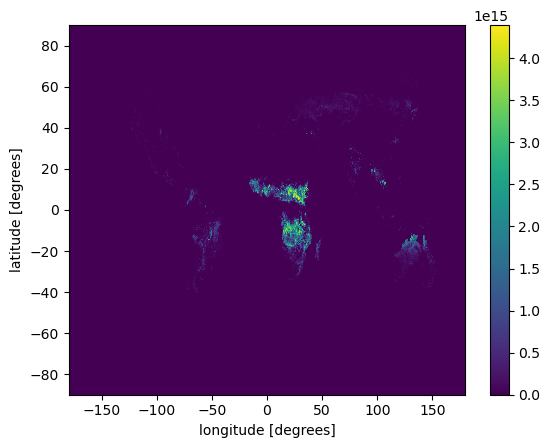

In [ ]:
ds = xr.open_zarr("https://s3.waw4-1.cloudferro.com/EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr", chunks={})

burned = (ds.fcci_ba * ds.area).sum("time")

global_burned = burned.sum(("latitude", "longitude")).compute()

print("Total burned area:", float(global_burned.values))

burned.plot(x="longitude", y="latitude")


In [ ]:
%%time
sentinel1_url = 'https://objectstore.eodc.eu:2222/68e13833a1624f43ba2cac01376a18af:ASP_ZARR/S1_out.zarr'
eodc_objectstore_ds = xr.open_zarr(sentinel1_url)
eodc_objectstore_ds

CPU times: user 1.36 s, sys: 238 ms, total: 1.59 s
Wall time: 2.75 s


<xarray.Dataset> Size: 140MB
Dimensions:              (time: 2853, field_id: 1023)
Coordinates:
  * field_id             (field_id) <U14 57kB 'cz_polk_N01-KB' ... 'ua_lviv_3'
    max_lat              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    max_lon              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    min_lat              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    min_lon              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    rep_lat              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    rep_lon              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    row_id               (field_id) object 8kB dask.array<chunksize=(1023,), meta=np.ndarray>
  * time                 (time) datetime64[ns] 23kB 2015-03-01 ... 2022-12-30
Data variables:
    sig0_cr_mean_daily   (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig0_vh_mean_daily   (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig0_vv_mean_daily   (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig40_cr_mean_daily  (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig40_vh_mean_daily  (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig40_vv_mean_daily  (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
Attributes: (12/19)
    country_co:  ua
    crop_damag:  na
    crop_id:     C1111
    crop_type:   common winter wheat
    data_openn:  0
    farm_code:   chmel
    ...          ...
    row_id:      1093
    soil_type:   na
    sowing_dat:  
    tilage:      na
    tilename:    E060N015T3
    yield:       7.93

In [ ]:
%%time
pd.Series(eodc_objectstore_ds.sig0_vh_mean_daily.values.flatten()).describe()

CPU times: user 147 ms, sys: 48.9 ms, total: 196 ms
Wall time: 1.03 s


count    238075.000000
mean        -19.419959
std           3.285195
min         -31.232473
25%         -21.997556
50%         -19.219452
75%         -16.864764
max          -8.850440
dtype: float64

In [ ]:
prr_ds = xr.open_dataset('remote_kerchunk_zip.json', engine='kerchunk', chunks={})
prr_ds

<xarray.Dataset> Size: 140MB
Dimensions:              (time: 2853, field_id: 1023, row_id: 1023)
Coordinates:
  * field_id             (field_id) <U14 57kB 'cz_polk_N01-KB' ... 'ua_lviv_3'
    max_lat              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    max_lon              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    min_lat              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    min_lon              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    rep_lat              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
    rep_lon              (field_id) float64 8kB dask.array<chunksize=(100,), meta=np.ndarray>
  * row_id               (row_id) <U34 139kB '20200,20276,20325,20381' ... '1...
  * time                 (time) datetime64[ns] 23kB 2015-03-01 ... 2022-12-30
Data variables:
    sig0_cr_mean_daily   (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig0_vh_mean_daily   (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig0_vv_mean_daily   (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig40_cr_mean_daily  (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig40_vh_mean_daily  (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
    sig40_vv_mean_daily  (time, field_id) float64 23MB dask.array<chunksize=(714, 50), meta=np.ndarray>
Attributes: (12/19)
    country_co:  ua
    crop_damag:  na
    crop_id:     C1111
    crop_type:   common winter wheat
    data_openn:  0
    farm_code:   chmel
    ...          ...
    row_id:      1093
    soil_type:   na
    sowing_dat:  
    tilage:      na
    tilename:    E060N015T3
    yield:       7.93

In [ ]:
%%time
pd.Series(prr_ds.sig0_vh_mean_daily.values.flatten()).describe()

CPU times: user 180 ms, sys: 40.2 ms, total: 221 ms
Wall time: 818 ms


count    238075.000000
mean        -19.419959
std           3.285195
min         -31.232473
25%         -21.997556
50%         -19.219452
75%         -16.864764
max          -8.850440
dtype: float64

In [ ]:
# --- workload: eodc ---
def _job():
    sentinel1_url = 'https://objectstore.eodc.eu:2222/68e13833a1624f43ba2cac01376a18af:ASP_ZARR/S1_out.zarr'
    eodc_objectstore_ds = xr.open_zarr(sentinel1_url)
    # Touch the data to force IO; .values will pull the referenced bytes
    out = pd.Series(eodc_objectstore_ds.sig0_vh_mean_daily.values.flatten()).describe()
    eodc_objectstore_ds.close()
    return out


In [ ]:
# --- workload: your kerchunk/xarray open + compute ---
def _job():
    ds = xr.open_dataset('remote_kerchunk_zip.json', engine='kerchunk', chunks={})
    # Touch the data to force IO; .values will pull the referenced bytes
    out = pd.Series(ds.sig0_vh_mean_daily.values.flatten()).describe()
    ds.close()
    return out


In [ ]:
%%time
CONCURRENCY = 1
JITTER_MAX_S = 0.125          # up to 125ms random delay before each request

REQS = 0
FAILS = 0
_LOCK = threading.Lock()

def _hit(ok=True):
    global REQS, FAILS
    with _LOCK:
        if ok: REQS += 1
        else:  FAILS += 1

# --- patch aiohttp (used by fsspec/http + kerchunk async paths) ---
try:
    import asyncio, aiohttp
    _orig_aio = aiohttp.client.ClientSession._request
    async def _wrap_aio(self, method, url, *a, **k):
        try:
            # gentle staggering
            if JITTER_MAX_S > 0:
                await asyncio.sleep(random.random() * JITTER_MAX_S)
            _hit(True)
            return await _orig_aio(self, method, url, *a, **k)
        except Exception:
            _hit(False)
            raise
    aiohttp.client.ClientSession._request = _wrap_aio
except Exception:
    pass

# --- patch requests / urllib3 (many libs sync path) ---
try:
    import requests
    _orig_req = requests.Session.request
    def _wrap_request(self, method, url, *a, **k):
        try:
            if JITTER_MAX_S > 0:
                time.sleep(random.random() * JITTER_MAX_S)
            _hit(True)
            return _orig_req(self, method, url, *a, **k)
        except Exception:
            _hit(False)
            raise
    requests.Session.request = _wrap_request
except Exception:
    pass

try:
    from urllib3.connectionpool import HTTPConnectionPool, HTTPSConnectionPool
    _http_orig  = HTTPConnectionPool.urlopen
    _https_orig = HTTPSConnectionPool.urlopen
    def _wrap_urlopen(orig):
        def _u(self, method, url, *a, **k):
            try:
                if JITTER_MAX_S > 0:
                    time.sleep(random.random() * JITTER_MAX_S)
                _hit(True)
                return orig(self, method, url, *a, **k)
            except Exception:
                _hit(False)
                raise
        return _u
    HTTPConnectionPool.urlopen  = _wrap_urlopen(_http_orig)
    HTTPSConnectionPool.urlopen = _wrap_urlopen(_https_orig)
except Exception:
    pass


start = time.perf_counter()
with ThreadPoolExecutor(max_workers=CONCURRENCY) as ex:
    results = list(ex.map(lambda _: _job(), range(CONCURRENCY)))
elapsed = time.perf_counter() - start

# --- unpatch (optional good hygiene) ---
try: aiohttp.client.ClientSession._request = _orig_aio
except: pass
try: requests.Session.request = _orig_req
except: pass
try:
    HTTPConnectionPool.urlopen  = _http_orig
    HTTPSConnectionPool.urlopen = _https_orig
except: pass

print(f"Parallel runs: {len(results)}")
print(f"Total wall time (s): {elapsed:.3f}")
print(f"HTTP requests counted: {REQS}  | failures: {FAILS}")
print(f"Throughput (req/s): {REQS/elapsed:.2f}" if REQS else "Throughput (req/s): n/a")



In [ ]:
import time
import xarray as xr
URL = "https://eoresults.esa.int/e/earthcode/seasfire_tests/seasfire_v0.4.zarr"



In [ ]:
import time
import psutil
import xarray as xr
import dask.array as da
from sklearn.cluster import KMeans

# URL = "https://eoresults.esa.int/e/earthcode/seasfire_tests/seasfire_v0.4.zarr"
URL = "https://s3.waw4-1.cloudferro.com/EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr"
LARGE_JOB = False

# about 1 GB transferred
def larger_job():
    ds = xr.open_zarr(URL, chunks={})
    feat = xr.concat(
        [
            ds.cams_frpfire.isel(time=slice(-500, None)).mean("time"),
            ds.fwi_mean.isel(time=slice(-500, None)).mean("time"),
        ],
        "feature",
    ).isel(latitude=slice(None, None, 4), longitude=slice(None, None, 4)) \
     .stack(p=("latitude", "longitude")).transpose("p", "feature").fillna(0)

    return xr.DataArray(
        KMeans(4, n_init="auto").fit_predict(feat.compute().values),
        coords={"p": feat.p}, dims="p",
    ).unstack("p")

# about 110 MB transferred
def small_job():
    ds = xr.open_zarr(URL, chunks={})
    frp = ds.cams_frpfire
    return frp.mean(("time", "latitude", "longitude")).compute()


def net_bytes():
    """Total bytes sent/recv on this host (all interfaces)."""
    c = psutil.net_io_counters()
    return c.bytes_recv, c.bytes_sent


if __name__ == "__main__":
    recv0, sent0 = net_bytes()
    t0 = time.perf_counter()

    job = larger_job if LARGE_JOB else small_job

    labels = job()

    wall = time.perf_counter() - t0
    recv1, sent1 = net_bytes()

    d_recv = recv1 - recv0
    d_sent = sent1 - sent0
    total = d_recv + d_sent

    print(f"Wall time:         {wall:.2f} s")
    print(f"Bytes received:    {d_recv/1e6:.2f} MB")
    print(f"Bytes sent:        {d_sent/1e6:.2f} MB")
    print(f"Total bytes:       {total/1e6:.2f} MB")
    if wall > 0 and total > 0:
        print(f"Avg throughput:    {total/1e6 / wall:.2f} MB/s")


Wall time:         14.54 s
Bytes received:    110.44 MB
Bytes sent:        15.65 MB
Total bytes:       126.09 MB
Avg throughput:    8.67 MB/s


In [3]:
job()

<xarray.DataArray 'cams_frpfire' ()> Size: 4B
array(0.00156596, dtype=float32)